# Calibration (SIR model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.

For this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SIR model ($\alpha, \beta, \gamma_{I_a}, \gamma_{I_s}$).
Using the data after lockdown and these computed parameters, we infer the change of the contact structure.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory

In [15]:
# population and age classes (4 age groups, UK contact structure)
M=4  # number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]
        
N = N/5e2  # Scale the numbers to avoid numerical problems
Ni = Ni/5e2

In [16]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [17]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [18]:
beta  = 0.02       # contact rate parameter
gIa   = 1./7       # recovery rate of asymptomatic infectives 
gIs   = 1./7       # recovery rate of symptomatic infectives 
alpha = 0.2        # asymptomatic fraction
fsa   = 0.8        # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10  #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
true_parameters = parameters
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, C, Tf, Nf)

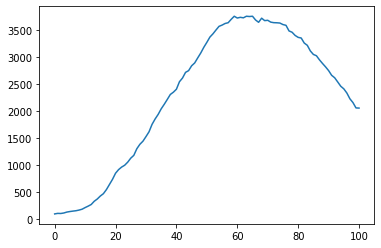

In [19]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

## 2) Infer the parameters of the model

-2236.3745050691846
0.23084735870361328


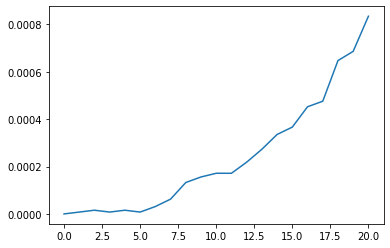

In [20]:
Tf = 20 # truncate to only getting the first few datapoints (up to lockdown) 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

plt.plot(x[:, M])
plt.show()

In [21]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])

start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, generator.constant_CM, bounds=bounds, 
                             global_max_iter=20, eps=eps, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=933070, Thu May  7 14:54:46 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.131765561679765e+03 1.0e+00 1.02e+00  4e-02  1e-01 0:04.2
    2     32 -2.016263076530218e+03 1.6e+00 8.57e-01  3e-02  1e-01 0:07.4
    3     48 -2.057735855524375e+03 1.7e+00 7.12e-01  2e-02  9e-02 0:10.8
    4     64 -2.217836416031363e+03 2.1e+00 6.56e-01  2e-02  8e-02 0:14.1
    6     96 -2.218109963822627e+03 3.4e+00 4.92e-01  7e-03  6e-02 0:20.5
    8    128 -2.237693491134134e+03 4.6e+00 4.66e-01  6e-03  5e-02 0:29.0
   11    176 -2.236985315398410e+03 5.6e+00 3.75e-01  3e-03  4e-02 0:37.4
   14    224 -2.243424723341624e+03 6.8e+00 1.97e-01  1e-03  2e-02 0:49.2
   17    272 -2.245542797256153e+03 1.1e+01 1.89e-01  8e-04  2e-02 0:59.4
   20    320 -2.245768581556865e+03 1.5e+01 1.05e-01  3e-04  9e-03 1:08.9
Optimal value (global minimisation):  -2245.793327910793
Starting

In [22]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(params)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

Inferred parameters:
[0.20394215 0.02005014 0.10970654 0.15026528]


## 3) Infer the change of contact structure

In [23]:
aW_g = 0.6 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])
stds = np.array([0.1, 0.2, 0.15])

x = data['X']/N
x = x[22:]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-7713.942083347999


In [24]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
params = estimator.infer_control(guess, stds, x, Tf, Nf, generator, bounds,
                                 global_max_iter=20, eps=eps, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=1010271, Thu May  7 14:58:03 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.521301180041974e+03 1.0e+00 9.94e-01  9e-02  2e-01 0:12.3
    2     32 -7.522356465267902e+03 1.3e+00 1.17e+00  1e-01  2e-01 0:24.6
    3     48 -7.523035339548263e+03 1.9e+00 1.24e+00  1e-01  2e-01 0:36.4
    4     64 -7.533802590759508e+03 2.2e+00 1.17e+00  1e-01  2e-01 0:48.0
    5     80 -7.528408982614525e+03 3.0e+00 1.18e+00  1e-01  2e-01 0:60.0
    6     96 -7.535055145596459e+03 3.5e+00 8.83e-01  7e-02  2e-01 1:14.0
    7    112 -7.533312786110526e+03 4.2e+00 7.03e-01  5e-02  1e-01 1:28.6
    8    128 -7.534465833713986e+03 4.1e+00 6.10e-01  4e-02  8e-02 1:40.4
    9    144 -7.532678817534821e+03 4.3e+00 5.02e-01  3e-02  7e-02 1:51.6
   10    160 -7.535313166997467e+03 5.1e+00 4.42e-01  2e-02  6e-02 2:02.6
   11    176 -7.535188301920726e+03 5.6e+00 4.03e-01  2e-02  4e-

In [25]:
print("True lockdown factors:")
print([aW, aS, aO])

print("\nInferred lockdown factors:")
print(params)

True lockdown factors:
[0.5, 0.6, 0.6]

Inferred lockdown factors:
[0.50281188 0.61236158 0.59921254]
